# To be continued or discontinued: investigating secret formula for successful movie franchise
This notebook contains in-depth analysis and visualization for our project. Some figures in the blog post is taken from this notebook.

## Data loading and preprocessing

__Delete unused import before submission__

In [ ]:
%load_ext autoreload
%autoreload 2
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
from scipy.stats import zscore

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# custom functions
from src.data.utils import get_franchise_movies, get_inflation_rate, get_movie, clean_character_metadata, custom_autopct, create_ethnicity_columns, get_tree_df, get_genre_counts, get_franchise_data, clean_categories, get_1_2_movies
from src.utils.plotting import plot_geo_piecharts, plot_heatmap_1, plot_heatmap_2
from src.utils.importance import run_importance
sns.set_theme(style='darkgrid', palette='colorblind', color_codes=True)


We'll start by loading the character data and drop rows if any of the columns in `COL_FOR_DROPNA` is missing. This will make the following analysis easier without dropping too many rows (55467/395202 dropped).

__DO NOT EDIT THE LOADING ORDER OF `character_df`, `movies_df_raw`, `franchise_df` AND `movies_no_franchise_df`.__

In [2]:
COL_NAMES = [
    'Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 
    'Actor_date_of_birth', 'Actor_gender', 'Actor_height_m', 'Actor_ethnicity_Freebase_ID', 
    'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_actor_map_ID', 
    'Freebase_character_ID', 'Freebase_actor_ID'
]
COL_FOR_DROPNA = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date',
                  'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID',
                  'Freebase_actor_ID']
RANDOM_STATE = 42

In [60]:
# load and prepare character_df
character_df = pd.read_csv('data/character.metadata.tsv', names=COL_NAMES, sep='\t')
character_df = clean_character_metadata(character_df, mapping_path='data/ethnicity_mapping.csv', columns=COL_FOR_DROPNA)

#loading the inflation rate data set from the columbia bank
inflation_rate_df=get_inflation_rate()
#loading the complete data set 
movies_df_raw = pd.read_csv('data/movie_metadata_with_tmdb.csv')
movies_df_raw = create_ethnicity_columns(movies_df_raw, character_df)
#Data frame with all the movies with preprocessing
movies_df=get_movie(movies_df_raw,inflation_rate_df)

#loading the data set for the franchise movies 
franchise_df=get_franchise_movies(movies_df_raw,inflation_rate_df,'data/missing_dates_manualsearch.csv')
#Data frame with movies that are not part of a franchise
movies_no_franchise_df = movies_df[movies_df['collection_id'].isna()].reset_index(drop=True)

# create a new column to check if the movie is part of a franchise
character_df["is_in_franchise"] = character_df["Wikipedia_movie_ID"].isin(franchise_df["Wikipedia movie ID"])

#Data frame of only the franchise name and their characteristics
# franchise_data_df = get_franchise_data(franchise_df)

# Drop franchises where any movie in the franchise does not have a release date
# franchise_df_2 = franchise_df.groupby('collection_id').filter(lambda x: x['Movie release date'].notna().all())
# print("Number of movies with all movies having release dates : ", len(franchise_df_2))
# print(franchise_df)

Dropping character data rows with missing values in any of ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Actor_gender', 'Actor_name', 'Freebase_character_actor_map_ID', 'Freebase_actor_ID'].
Number of rows dropped: 55467
395202 rows remaining.
Running sentiment analysis...


100%|██████████| 52034/52034 [00:07<00:00, 7303.69it/s]


## First look of the data

In [61]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")
print(f"Number of movies in the entire data set: {len(movies_df['collection_id'])}")
print(f"Number of movies not in a collections: {len(movies_no_franchise_df)}")


count    1592.00000
mean        3.24309
std         3.75448
min         2.00000
25%         2.00000
50%         2.00000
75%         3.00000
max        66.00000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5163
Number of movies in the entire data set: 81740
Number of movies not in a collections: 75558


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 
Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).


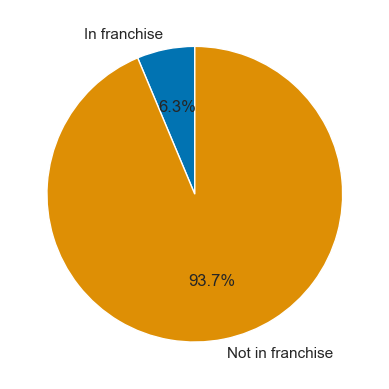

In [62]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

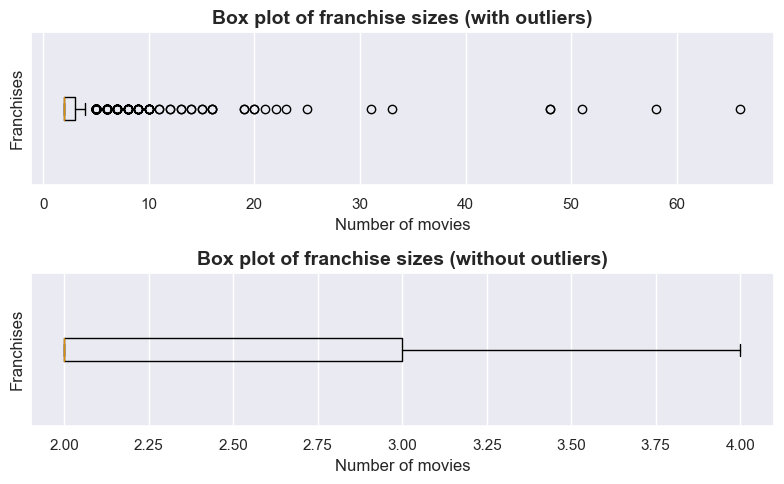

In [65]:
# Plot the box plot
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

# Boxplot with outliers
axes[0].boxplot(franchise_counts, vert=False)
axes[0].set_title('Box plot of franchise sizes (with outliers)',
                  fontweight='bold', fontsize=14)
axes[0].set_xlabel('Number of movies')
axes[0].set_ylabel('Franchises')
axes[0].set_yticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, vert=False, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)',
                  fontweight='bold', fontsize=14)
axes[1].set_xlabel('Number of movies')
axes[1].set_ylabel('Franchises')
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

In [64]:
from scipy.stats import zscore
# Performe the Z-scores for the franchise_counts
franchise_counts_zscores = zscore(franchise_counts)
franchise_counts2 = franchise_counts.to_frame(name='count')
franchise_counts2['zscore'] = franchise_counts_zscores

# Identify outliers (Z-score > 3 or < -3)
outliers_franchise_counts = franchise_counts2[(franchise_counts2['zscore'] > 3) | (franchise_counts2['zscore'] < -3)]
print(f"Number of outliers: {len(outliers_franchise_counts)}")

Number of outliers: 20


Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

## Univariate Analysis 

In this part we've investigated each column of the dataset and visualized what we are working with and compared movie in franchise and movie that aren't.

### Genres

Now, we wanted to look more closely at the genre columns, as it is one of the parameters needed to answer our research questions. First, let's plot the genre proportions in the original dataset, with all the movies. 

N.B.: most movies are defined by multiple genres and not a unique one

In [ ]:
# Calculate the total count of all genres
total_genres_count, genre_counts_df = get_genre_counts(movies_df_raw)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 10))

ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in dataset')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)

# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in dataset, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in dataset, comedies grouped, with "other" category')

plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

In [ ]:
# Calculate the total count of all genres
total_genres_count, genre_counts_df = get_genre_counts(franchise_df)
# Determine the threshold count for 2%
threshold_count = total_genres_count * 0.02
# Replace genres with counts below the threshold with an empty string for labels
labels = genre_counts_df.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)

# Plotting the pie chart with filtered labels
fig = plt.figure(figsize=(21, 10))
gs = GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(genre_counts_df['counts'], labels=labels, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax1.set_title('Distribution of Genres in Collections')

# Replace any genre containing "comedy" (case-insensitive) with "comedy"
genre_counts_df['genre'] = genre_counts_df['genre'].str.replace(r'(?i).*comedy.*', 'Comedy', regex=True)


# Group by genre and sum counts
old_genre_counts = genre_counts_df.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
labels2 = old_genre_counts.apply(lambda row: '' if row['counts'] < threshold_count else row['genre'], axis=1)
# Plotting the pie chart
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(old_genre_counts['counts'], labels=labels2, autopct=lambda p: '' if p < 2 else f'{p:.1f}%', wedgeprops={'edgecolor': 'none'})
ax2.set_title('Distribution of Genres in Collections, comedies grouped')

# Replace genres with counts below the threshold with "other"
old_genre_counts['genre'] = old_genre_counts.apply(lambda row: 'other' if row['counts'] < threshold_count else row['genre'], axis=1)
old_genre_counts = old_genre_counts.groupby('genre', as_index=False)['counts'].sum()
old_genre_counts = old_genre_counts.sort_values(by='counts', ascending=False)
# Plotting the pie chart
ax3 = fig.add_subplot(gs[0, 2])
ax3.pie(old_genre_counts['counts'], labels=old_genre_counts['genre'], autopct='%1.1f%%')
ax3.set_title('Distribution of Genres in Collections, comedies grouped, with "other" category')

# Extract top 5 and bottom 5 genres
top_5_genres = genre_counts_df.head(5)
bottom_5_genres = genre_counts_df.tail(5)
# Combine top 5 and bottom 5 genres into a single DataFrame
top_bottom_genres = pd.concat([top_5_genres, bottom_5_genres])

# Plot the table with top 5 and bottom 5 genres
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# Create the table
table = ax4.table(cellText=top_bottom_genres.values,
                 colLabels=top_bottom_genres.columns,
                 cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Display the table
plt.show()

Now, let's compare with the distribution in the movies in franchises subset:

Now, we know that there are a lot of unique, very specific and irrelevant genres in the original categories (such as "Kitchen sink realism"), that appear less than 2% and together represent 42% of the whole genres. We therefore chose to use the ones in the added TMDB dataset.

In [ ]:
# Flatten the list of genres and count the occurrences
flattened_genres = [genre for sublist in franchise_df['genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
genre_counts_df.columns = ['genre', 'count']

# Calculate the proportion of each genre
genre_counts_df['proportion [%]'] = genre_counts_df['count'] / genre_counts_df['count'].sum() * 100
genre_counts_df = genre_counts_df.sort_values(by='proportion [%]', ascending=False)
genre_counts_df['proportion [%]'] = genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot the table with genre proportions
ax1.axis('off')
table = ax1.table(cellText=genre_counts_df[['genre', 'proportion [%]']].values,
                  colLabels=['Genre', 'Proportion [%]'],
                  cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(12)  # Increase font size
table.scale(1.2, 1.5)  # Scale for better spacing

# Adding color to the header and rows
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(14)
        cell.set_text_props(weight='bold')  # Make header text bold
        cell.set_facecolor('#6a7ba2')  # Green background for header
        cell.set_text_props(color='white')  # White text color for the header
    else:
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2')  # Light gray color for alternate rows
        else:
            cell.set_facecolor('#ffffff')  # White color for other rows

    # Set border style
    cell.set_edgecolor('black')  # Add black borders to cells

# Plot the pie chart with labels only on the side
wedges, texts, autotexts = ax2.pie(genre_counts_df['count'], labels=['']*len(genre_counts_df), autopct='%1.1f%%')
ax2.legend(wedges, genre_counts_df['genre'], title="Genres", loc="center", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title('Distribution of Genres in Collections')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1., 1.)

plt.show()

This looks better ! And we still have the same top 3 genre ! Let's now compare our franchise movies to non franchise movies, to see if they seem to follow the same distribution:

In [ ]:
# Extract genres proportions for movies not in franchise, as done before
nf_flattened_genres = [genre for sublist in movies_df['genres'] for genre in sublist]
nf_genre_counts = Counter(nf_flattened_genres)
nf_genre_counts_df = pd.DataFrame.from_dict(nf_genre_counts, orient='index', columns=['count']).reset_index()
nf_genre_counts_df.columns = ['genre', 'count']
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['count'] / nf_genre_counts_df['count'].sum() * 100
nf_genre_counts_df = nf_genre_counts_df.sort_values(by='proportion [%]', ascending=False)
nf_genre_counts_df['proportion [%]'] = nf_genre_counts_df['proportion [%]'].apply(lambda x: round(x, 1))

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot the higher bars (franchise) first
sns.barplot(
    x="genre", y="proportion [%]", data=genre_counts_df,
    color="skyblue", label="Franchise Movies"
)

# Plot the lower bars (non-franchise) second
sns.barplot(
    x="genre", y="proportion [%]", data=nf_genre_counts_df,
    color="orange", alpha=0.8, label="Non-Franchise Movies"
)

# Add labels, legend, and rotate x-axis labels for better visibility
plt.xticks(rotation=90)
plt.legend()
plt.title("Genre Proportions: Franchise vs. Non-Franchise Movies")
plt.tight_layout()

plt.show()

### Time representation

For this part we used the released date as the main variable to analyze first the movies in the franchise collection and then the franchise as a whole

#### Distribution of the release year of movies in a franchise vs the whole CMU dataset

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12, 4))

# Plot the histogram for franchise_df
ax[0].hist(franchise_df['release_year'].dropna(), bins=range(int(franchise_df['release_year'].min()), int(franchise_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, label='franchise_df')
ax[0].set_xlabel('Release Year')
ax[0].set_ylabel('Number of Movies in franchise_df', color='b')
ax[0].tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the movies_df histogram
ax2 = ax[0].twinx()
ax2.hist(movies_df['release_year'].dropna(), bins=range(int(movies_df['release_year'].min()), int(movies_df['release_year'].max()) + 1), edgecolor='black', alpha=0.5, color='r', label='movies_df')
ax2.set_ylabel('Number of Movies in movies_df', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Histogram of Number of Movies per Release Year')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax[0].transAxes)


# Plot the KDE for franchise_df
sns.kdeplot(franchise_df['release_year'].dropna(), ax=ax[1], label='franchise_df', color='blue')

# Plot the KDE for movies_df
sns.kdeplot(movies_df['release_year'].dropna(), ax=ax[1], label='movies_df', color='red')

# Set labels and title
ax[1].set_xlabel('Release Year')
ax[1].set_ylabel('Density')
ax[1].set_title('KDE Plot of Number of Movies per Release Year')
ax[1].legend()

plt.show()

We observe that the subset we created from the CMU Movie dataset by extracting the franchise of at least 2 movies has more or less the same distribution of release year. Note that the CMU Movie dataset has 8% missing date. The franchise one has none since it is really necessary to know the order of the movie in a franchise, the missing release date missing were recovered.

#### Franchise length and movie release frequency

The franchise_data_df is the dataframe of all the franchise and add the different characteristics: total revenue (if all the movie have a revenue), average vote of the franchise, number of movies, oldest movie release date of the franchise, most recent release date of the franchise, length and average time between the movies in a franchise.

In [ ]:
#Data frame of only the franchise name and their characteristics
franchise_data_df = get_franchise_data(franchise_df)

# Count the number of franchise with the same length
franchise_data_df_length = franchise_data_df['franchise_length_years'].value_counts().reset_index()
franchise_data_df_length.columns = ['franchise_length_years', 'count']

# Count the number of franchise with the same average years between movies
franchise_data_df_avbm = franchise_data_df['average_years_bt_movies'].value_counts().reset_index()
franchise_data_df_avbm.columns = ['average_years_bt_movies', 'count']
# Create bins for each year
bins = np.arange(franchise_data_df_avbm['average_years_bt_movies'].min(), franchise_data_df_avbm['average_years_bt_movies'].max() + 1, 1)

# Count the number of movie with the same year gap between the previous movie
franchise_df_ydbpm = franchise_df['years_diff_bt_pre_movies'].value_counts().reset_index()
franchise_df_ydbpm.columns = ['years_diff_bt_pre_movies', 'count']


# Plotting the bar chart
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].bar(franchise_data_df_length['franchise_length_years'], franchise_data_df_length['count'])
ax[0].set_xlabel('Collection Length in Years')
ax[0].set_ylabel('Number of franchise')
ax[0].set_title('Distribution of Franchise Lengths in Years')

ax[1].hist(franchise_data_df['average_years_bt_movies'], bins=bins, edgecolor='white')
ax[1].set_xlabel('Average Years Between Movies')
ax[1].set_ylabel('Number of franchise')

ax[1].set_title('Distribution of the frequency of the Movies in a Franchise')
plt.show()

In [ ]:
# outsiders
#franchise of more than 20 years
long_franchise = franchise_data_df[franchise_data_df['franchise_length_years'] > 20]
print(long_franchise['collection_name'])
#franchise witha an average of more than 15 years between movies
long_average = franchise_data_df[franchise_data_df['average_years_bt_movies'] > 15]
print(long_average['collection_name'])


We observe that the vast majority of the franchise are in a close range with still pretty big range. We're going to use this parameter to describe the franchise in a following part.

### Vote distribution

In [ ]:
# kde plot of the average vote for all the franchise

fig, ax = plt.subplots(figsize=(10, 6))
average_vote = franchise_df[franchise_df['vote_average'] > 0]['vote_average'].median()
average_vote2 = movies_df[movies_df['vote_average'] > 0]['vote_average'].median()
ax.axvline(average_vote, color='b', linestyle='--', label=f'Median franchise: {average_vote:.2f}')
ax.axvline(average_vote2, color='r', linestyle='--', label=f'Median non-franchise: {average_vote2:.2f}')
sns.kdeplot(franchise_df[franchise_df['vote_average'] > 0]['vote_average'].dropna(), ax=ax, label='franchise_df', color='blue')
sns.kdeplot(movies_df[movies_df['vote_average'] > 0]['vote_average'].dropna(), ax=ax, label='movies_df', color='red') 
ax.set_xlabel('Average Vote')
ax.set_ylabel('Density')
ax.set_title('KDE Plot of Average Vote for all the franchise')
ax.legend()
plt.show()

We see that the Franchise movies are slightly better graded !

In [ ]:
# Calculate mean and standard deviation
summary_stats = franchise_df.groupby("movie_order")["vote_average"].agg(
    mean_vote="mean",
    std_vote="std"
).reset_index()
print(summary_stats)
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_stats,
    x="movie_order",
    y="mean_vote",
    ci="sd",
    color="skyblue"
)

# Customize the plot
plt.title("Vote Average by Movie Order with Error Bars", fontsize=14, fontweight="bold")
plt.xlabel("Movie Order", fontsize=12)
plt.ylabel("Vote Average", fontsize=12)
plt.ylim(0, 10)  # Limit y-axis to the range 0-10
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=franchise_df, x='movie_order', y='vote_average', ci='sd')

# Customize the plot
plt.title("Vote Average by Movie Order with Error Bars", fontsize=14, fontweight="bold")
plt.xlabel("Movie Order", fontsize=12)
plt.ylabel("Vote Average", fontsize=12)
plt.ylim(0, 10)  # Limit y-axis to the range 0-10
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


And that the second movie has a worse grade than the first !

### Countries repartition 

Now, we want to focus on the franchises' countries of origin (using the tmdb dataset), and look at how they interact. First we plotted a pie chart to get a first look at which countries are most respresented in the dataset.

In [ ]:
plot_geo_piecharts(movies_df, franchise_df, movies_no_franchise_df)

Now, let's look at how they interact: the nodes in the plot below represent how often the country is the origin of a movie, and the edges indicate that two countries are listed together as the origin countries.

In [ ]:
from src.utils.plotting import plot_network

plot_network(franchise_df)

# Filter out 'Republic of Macedonia' from movies_df before plotting
#filtered_movies_df = movies_df[movies_df['tmdb_origin_country'] != 'Republic of Macedonia']
# Check if filtering works as expected
#print('Republic of Macedonia' not in filtered_movies_df['tmdb_origin_country'].values, "Filtering did not remove 'Republic of Macedonia'.")
plot_network(movies_df)

### Actor identity analysis

In this part, we will particularly tackle Q2-3 of our research questions. That is:

> 2-3: Do actors of certain ethnicity/gender groups appear more or less commonly in franchise movies? Are they depicted positively (hero/heroine) or negatively (villain) in the movie?

#### Actor gender distribution
To begin with, we'll look at actor gender distribution of franchise and non-franchise movies.

In [ ]:
# Calculate the proportion of each gender for character_df
gender_proportion_non_fr = character_df[~character_df['is_in_franchise']]['Actor_gender'].value_counts()
# Calculate the proportion of each gender for fr_character_df
gender_proportion_franchise = character_df[character_df["is_in_franchise"]]['Actor_gender'].value_counts()
# Plot the gender proportions as pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# Plot for fr_character_df
gender_proportion_franchise.plot(kind='pie', ax=axes[0], autopct=custom_autopct(gender_proportion_franchise),
                                 startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'],
                                 fontsize=12)
axes[0].set_ylabel('')
axes[0].set_title('Franchise movies', fontsize=14)

# Plot for character_df
gender_proportion_non_fr.plot(kind='pie', ax=axes[1], autopct=custom_autopct(gender_proportion_non_fr),
                           startangle=90, labels=['Male', 'Female'], colors=['#1f77b4', '#feb5da'], fontsize=12)
axes[1].set_ylabel('')
axes[1].set_title('Non-franchise movies', fontsize=14)
# Set overarching title
fig.suptitle('Gender distribution comparison', fontsize=18)
plt.tight_layout()
plt.show()

It seems that actor gender distribution remains the same for franchise and non-franchise movies. This is unsurprising as most of us can agree that there are particulalry many female characters in franchise movies than non-franchise movies, at least anecdotally.

#### Racial group
Next, we shift our focus to ethnicity groups. Contrary to actor gender information, actor ethnicity is not available for the majority of actors (available for 99719/395202 $\approx$ 25.2%). Upon observing the dataset, we hypothesized that the actors with known ethnicity are those with more publicity and therefore, more likely to play main roles in the movies. The ethnicity distribution of these main actors can be representative of which racial group is more or less featured in the movie. Bearing this in mind, we will proceed to visualize actors' racial group distribution for franchise and non-franchise movies.

In [ ]:
# Define colors for racial groups
colors = dict(zip(['White', 'Black', 'Asian', 'Middle Eastern', 'Hispanic', 'Native American', 'Others'], sns.color_palette("colorblind", 7)))

# Calculate the percentage of each racial group for franchise and non-franchise movies
racial_proportion_franchise = character_df[character_df["is_in_franchise"]].value_counts("racial_group")
racial_proportion_non_franchise = character_df[~character_df['is_in_franchise']].value_counts("racial_group")
percentage_fr = (racial_proportion_franchise / racial_proportion_franchise.sum()) * 100
percentage_non_fr = (racial_proportion_non_franchise / racial_proportion_non_franchise.sum()) * 100
fr_count = racial_proportion_franchise.sum()
non_fr_count = racial_proportion_non_franchise.sum()

# Plot the racial percentages as horizontal bar charts side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot for franchise movies
bars_fr = percentage_fr.plot(kind='barh', ax=axes[0], color=[colors[group] for group in percentage_fr.index], edgecolor='black')
axes[0].set_title(f'Franchise Movies (total: {fr_count})', fontsize=14)
axes[0].set_xlabel('Percentage [%]')
axes[0].set_ylabel('Racial Group')
axes[0].invert_yaxis()  # Inverse y-axis
axes[0].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_fr.patches:
    axes[0].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center')

# Plot for non-franchise movies
bars_non_fr = percentage_non_fr.plot(kind='barh', ax=axes[1], color=[colors[group] for group in percentage_non_fr.index], edgecolor='black')
axes[1].set_title(f'Non-Franchise Movies (total: {non_fr_count})', fontsize=14)
axes[1].set_xlabel('Percentage [%]')
axes[1].set_ylabel('Racial Group')
axes[1].invert_yaxis()  # Inverse y-axis
axes[1].set_xlim(0, 55)  # Set x-axis range

# Annotate bars with percentage values
for bar in bars_non_fr.patches:
    axes[1].text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}%', va='center', fontsize=12)

# Set overarching title
fig.suptitle('Racial Group Distribution Comparison', fontsize=18)

plt.tight_layout()
plt.show()

The percentages in each of the plots above sum up to 100%. Notice that compared to non-franchise movies, franchise movies have fewer percentage of Asian actors (Franchise: 14.78%, Non-franchise: 31.18%). If we compared this to the 4 pie charts from `Countries repartition` section, the two pie charts on the righthand side of the figure show that the proporitions of movies from Asia (excluding Russia, Oceania and Middle East) in franchise and non-franchise movies are not as different as the disparity observed earlie in Asian actor percentages.

This means that the disparity in the percentage of Asian actors comes from factors other than movie production location. It is hard to identify the exact cause for this from our analysis only, but a potential confounding factor is the difference in genres: perhaps certain movie genres are more likely to be franchised which are underrepresented by Asian actors.

#### Sentimental analysis

In this section what are the typical adjectives used to positively or negatively describe the character?

In [ ]:
# Generate text for positive and negative sentiment scores
positive_text = ",".join(character_df[character_df.sentiment_score > 0.1].Adjectives)
negative_text = ",".join(character_df[character_df.sentiment_score < -0.1].Adjectives)

# Create word clouds
positive_wordcloud = WordCloud(width=600, height=600, background_color='white',
                               min_font_size=10, max_words=30).generate(positive_text)
negative_wordcloud = WordCloud(width=600, height=600, background_color='white',
                               min_font_size=10, max_words=30).generate(negative_text)

# Plot the word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(positive_wordcloud)
axes[0].set_title('Positive Adjectives', fontsize=30, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(negative_wordcloud)
axes[1].set_title('Negative Adjectives', fontsize=30, fontweight='bold')
axes[1].axis('off')

plt.show()


Box plot - no racial group stands out in terms of distribution.

In [ ]:
# Plot box plots of sentiment_score for each racial group
plt.figure(figsize=(12, 8))
character_df[character_df.is_in_franchise].dropna(subset=['sentiment_score']).boxplot(column='sentiment_score', by='racial_group', grid=False)
movie_count = len(character_df.dropna(subset=['sentiment_score']))
plt.title(f'Sentiment Scores by Racial Group (total: {movie_count})')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xlabel('Racial Group')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()

### Movie revenue box office

In [23]:
franchise_revenue = franchise_df.dropna(subset=['real_revenue'])
movies_revenue = movies_df.dropna(subset=['real_revenue']) 
movies_no_franchise_revenue = movies_no_franchise_df.dropna(subset=['real_revenue'])

All the revenue and budget are renamed real because : all the expenses are tacking into account the inflation rate at for each movie release time using this formula : Real Price = Nominal Price (at the time) × CPI in Base Year / CPI in Year of Price
The chosen base year is 2024. 
The CPI data are from the federal reserve bank of mineapolise (https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1800) 

In [ ]:
all_revenue= pd.DataFrame({
        'non-franchise movies': movies_no_franchise_revenue['real_revenue'], #movie_box['Movie box office revenue'],
        'franchise movies': franchise_revenue['real_revenue'], # box_office_df['Movie box office revenue']
        'all movies': movies_revenue['real_revenue']
        })
print(all_revenue.describe())
#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_revenue.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers')
    
# Plot without outliers
all_revenue.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers')
    
fig.text(0.04, 0.5, 'Box Office Revenue [$]', va='center', rotation='vertical')
plt.suptitle('Comparison of Movie Box Office Revenue ')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()

In average frachise movies gain five times more money then non franchise movies.

In [ ]:
ax = sns.barplot(data=all_revenue)
plt.title('Bar chart of Movie Box Office Revenue', fontweight="bold")
plt.ylabel('Box Office Revenue')
plt.show()

# Perform independent (we assume they are) t-test (Welch's t-test, assuming unequal variances)
t_stat, p_value = stats.ttest_ind(all_revenue['franchise movies'].dropna(), all_revenue['non-franchise movies'].dropna(), equal_var=False)
print("T-test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
if p_value < 0.05:
    print("The difference in means is statistically significant (p < 0.05).")
else:
    print("The difference in means is not statistically significant (p >= 0.05).")

### Movie budget

In [ ]:
all_budget= pd.DataFrame({
        'non-franchise movies': movies_no_franchise_revenue['real_budget'], #movie_box['Movie box office revenue'],
        'franchise movies': franchise_revenue['real_budget'], # box_office_df['Movie box office revenue']
        'all movies': movies_revenue['real_budget']
        })
print(all_budget.describe())
#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_budget.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers', fontweight='bold', fontsize=14)
    
# Plot without outliers
all_budget.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers', fontweight='bold', fontsize=14)
    
fig.text(0.04, 0.5, 'Movie budget [$]', va='center', rotation='vertical')
plt.suptitle('Comparison of movie budget', fontweight='bold', fontsize=20)
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()

In average, franchise movies has twice the budget then non franchise movies. 

Comparing movie revenue and budget along the movie order in a collection

In [ ]:
plt.figure(figsize=(10, 6))
expenses = franchise_revenue[franchise_revenue['movie_order'] <= 11].melt(id_vars='movie_order', value_vars=['real_revenue', 'real_budget'], 
                                 var_name='Type', value_name='expenses')
sns.barplot(x='movie_order', y='expenses', hue='Type', data=expenses, palette=['skyblue', 'darkblue'])

plt.xlabel('Movie Order')
plt.ylabel('Expenses [$]')
plt.title('Mean revenue and mean budget of movies by their order in the collection',fontsize=14, fontweight='bold')
plt.legend()
plt.show()

In [ ]:
all_ratio = pd.DataFrame({
        'non-franchise movies': movies_no_franchise_revenue['real_revenue']/movies_no_franchise_revenue['real_budget'],
        'franchise movies': franchise_revenue['ratio_revenue_budget'],
        })

fig.text(0.04, 0.5, 'Ratio Revenue over budget', va='center', rotation='vertical')

# Plot without outliers
sns.boxplot(all_ratio,color='skyblue', showfliers=False)
plt.title('Mean ratio (revenue/budget) sorted by their order in the franchise (ouliters excluded)', fontsize=14, fontweight='bold')
plt.ylabel('Ratio revenue over budget')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()

In average franchise movies has a twice the revenu over budget ratio then other (non franchise:1.501632 ; franchise 3.647577). This implies that with less expenses (budget) a franchise movie tends to gain more revenue. Hence it could be a less risky investement then a single movie. Be aware, the median does not give the same result. Be aware, the median does not give the same result. 

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="movie_order", y="ratio_revenue_budget", data=franchise_revenue[franchise_revenue['movie_order'] <= 11], color='skyblue', showfliers=False)
plt.xlabel('Movie Order')
plt.ylabel('Ratio revenue over budget')
plt.title('Mean ratio (revenue/budget) sorted by their order in the franchise (ouliters excluded)', fontsize=14, fontweight='bold')
plt.show()

Franchise with revenue and budget values exist, and more then 11 movies, but only a few. Therefore we don't have enough information for movies that are the twelth and more. This is why they are not shown. 

The plot under is an exemple of the interaction plot that you can find in the web site page 2

In [ ]:
sw = franchise_revenue[franchise_revenue['collection_name'] == 'Star Wars Collection'].sort_values(by='release_year')

Star_wars = sw.melt(id_vars='Movie name', value_vars=['real_budget','real_revenue'], 
                             var_name='Value', value_name='Expenses [$]')

sns.barplot(x='Movie name', y='Expenses [$]', hue='Value', data=Star_wars, palette=['skyblue', 'darkblue'])
plt.title('Budget and Revenue of Star Wars Franchises')
plt.xticks(rotation=45, ha='right')
plt.show()

## Bivariate analysis 

In this part we're going to look at the possible interaction 2 features have with another, this the first step to try to observe patterns or links.

### Movie revenue \& budget 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget',data=movies_no_franchise_revenue,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=franchise_revenue,alpha=.25, ax=axes[1])

# scatter plot of the real profit and years diff bt pre movies
sns.scatterplot(x='real_revenue', y='real_budget', data=movies_revenue,alpha=.25, ax=axes[2])
# Calculate Pearson correlation

pearson_corr_df = pd.DataFrame({
    'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='pearson').iloc[0, 1]
    ]
})

spearman_corr_df = pd.DataFrame({'Movies': ['All Movies', 'Franchise Movies', 'Non-Franchise Movies'],
    'Pearson Correlation': [
        movies_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1],
        movies_no_franchise_revenue[['real_revenue', 'real_budget']].corr(method='spearman').iloc[0, 1]
    ]
})

axes[0].set_title(f'Not in franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[0,1]:.2f}')
axes[1].set_title(f'Franchise movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[1,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[1,1]:.2f}')
axes[2].set_title(f'All movies\n'f'Pearson Correlation: {pearson_corr_df.iloc[2,1]:.2f}\nSpearman Correlation: {spearman_corr_df.iloc[2,1]:.2f}');


A significant correlation is observed between budget and revenue, which increases for franchsie movies. 

### Genre \& revenue

In [ ]:
# Explode the genres column so that each genre gets its own row
exploded_df = franchise_df.explode('genres').reset_index(drop=True).sort_values(by='real_revenue', ascending=False)
# Sort the genres by their average revenue
genre_revenue = exploded_df.groupby('genres')['real_revenue'].mean().sort_values(ascending=False).index
exploded_df['genres'] = pd.Categorical(exploded_df['genres'], categories=genre_revenue, ordered=True)
ax = sns.barplot(x="genres", y="real_revenue", data=exploded_df)
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted box Office Revenue by Genre, all movies in franchise')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()
#print(exploded_df.groupby('genres')['real_revenue'].describe())

We see that Adventure, Fantasy, and Animation are the highest-grossing genres for franchise movies.

NB : If a category doesn't have a barplot, it means that there is no data. Lack of error bars means only one movie is in that category.

Now, let's look at the profit, between the first and the second movie :

In [ ]:
f_and_s = exploded_df[exploded_df['movie_order'].isin([1.0, 2.0])] # First and second movies in each collection
print(len(f_and_s))
ax = sns.barplot(x="genres", y="ratio_revenue_budget", data=f_and_s.sort_values(by='ratio_revenue_budget', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Revenue to Budget Ratio')
plt.xlabel('Genre')
plt.title('Revenue to Budget Ratio by Genre, and order')
plt.yscale('log')  # Logarithmic scale for better readability
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Keep first and second movies separately
high_ratio_second_movies = f_and_s[(f_and_s['movie_order'] == 2)].sort_values(by='ratio_revenue_budget', ascending=False)
high_ratio_first_movies = f_and_s[(f_and_s['movie_order'] == 1)].sort_values(by='ratio_revenue_budget', ascending=False)

# Print the filtered DataFrame
print("First movies :\n", high_ratio_first_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10), "\n Second movies :\n", high_ratio_second_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10))

Action and adventure movies have higher revenue/budget ratio in second movie vs in first, but very high error bars: we decided to look at the eventual outliers, and found notably kickboxer 2. We notice that it is the only one of the kickboxers to have the ratio data: we therefore decided to filter out the movies that are the only ones to have the money information from their collection.

In [ ]:
f_and_s_filtered = f_and_s.groupby('collection_id').filter(lambda x: x['ratio_revenue_budget'].notna().all())
print(len(f_and_s_filtered))
ax = sns.barplot(x="genres", y="ratio_revenue_budget", data=f_and_s_filtered.sort_values(by='ratio_revenue_budget', ascending = True), hue='movie_order', palette='bright')
plt.ylabel('Revenue to Budget Ratio')
plt.xlabel('Genre')
plt.title('Revenue to Budget Ratio by Genre, and order')
plt.yscale('log')  # Logarithmic scale for better readability
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Filter the second movies with higher ratio_revenue_budget
high_ratio_second_movies = f_and_s_filtered[(f_and_s_filtered['movie_order'] == 2)].sort_values(by='ratio_revenue_budget', ascending=False)
high_ratio_first_movies = f_and_s_filtered[(f_and_s_filtered['movie_order'] == 1)].sort_values(by='ratio_revenue_budget', ascending=False)

# Print the filtered DataFrame
print("First movies :\n", high_ratio_first_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10), "\n Second movies :\n", high_ratio_second_movies[['Movie name', 'genres', 'ratio_revenue_budget']].head(10))

After that, we see that the first movie works a lot better than the second, for every category. We still have around 1500 movies, which is still good. And if we look at the box-office performance only ?

In [ ]:
# Sort the genres by their average revenue
genre_revenue = f_and_s_filtered.groupby('genres')['real_revenue'].mean().sort_values(ascending=False).index
f_and_s_filtered['genres'] = pd.Categorical(f_and_s_filtered['genres'], categories=genre_revenue, ordered=True)
ax = sns.barplot(x="genres", y="real_revenue", data=f_and_s, hue='movie_order', palette='bright')
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted Revenue by Genre, only first and second movies in each collection')
plt.xticks(rotation=90)
plt.show()
print(len(f_and_s_filtered))

Except for thrillers, Crime, Romance and Documentaries, the first movie performs on average better than the second. Nonetheless, they were still less profitable than the first movies.

And just to be sure, let's look at the first plot again, but with the filtered data:

In [ ]:
# Sort the genres by their average revenue
exploded_filtered = exploded_df.groupby('collection_id').filter(lambda x: x['real_revenue'].notna().all())
# Sort the genres by their average revenue
genre_revenue = exploded_filtered.groupby('genres')['real_revenue'].mean().sort_values(ascending=False).index
exploded_filtered['genres'] = pd.Categorical(exploded_filtered['genres'], categories=genre_revenue, ordered=True)
ax = sns.barplot(x="genres", y="real_revenue", data=exploded_filtered)
plt.ylabel('Adjusted box Office Revenue')
plt.xlabel('Genre')
plt.title('Adjusted box Office Revenue by Genre, all movies in franchise')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

We see that the 8 highest-grossing genres for the entire collections are still the same !

### Genre \& movie order

In [ ]:
# Create a bar plot of the number of genres depending on the order of the movie in a franchise
drop_no_genre = franchise_df[franchise_df['num_genres'] > 0]
plt.figure(figsize=(12, 6))
sns.barplot(x='movie_order', y='num_genres', data=drop_no_genre)

# Add labels and title
plt.xlabel('Movie Order')
plt.ylabel('Number of Genres')
plt.title('Number of Genres in a Movie Depending on the Order of the Movie in a Franchise')
# Rotate bar x-axis labels plot for better readability
plt.xticks(rotation=90)
# Adjust layout to add padding
plt.tight_layout(pad=3.0)

# Show the plot
plt.show();

We know that 75% of the franchises have between 2 and 4 movies, and here we can see that for these franchises, and for the first movies of longer franchises, the number of genres does not seem to change much. Maybe they switched though ? 
And for longer franchises, we see that the number of genres seems to decrease, and oscillate quite weirdly.
Now, let's see if the genres change between two consecutive movies

In [ ]:
# Reset the index of the DataFrame
drop_no_genre = drop_no_genre.reset_index(drop=True)

# Create a new column to indicate if the genre switched between two movies in a franchise
drop_no_genre['genre_switched'] = drop_no_genre.groupby('collection_id')['genres'].apply(lambda x: x != x.shift()).reset_index(drop=True)

# Plot for every movie in the franchise
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='movie_order', hue='genre_switched', data=drop_no_genre[['movie_order', 'genre_switched']].astype(int), palette='Set1', ax=ax)
ax.set_xlabel('Movie Order')
ax.set_ylabel('Count')
ax.set_title('Genre Switch Between Consecutive Movies in a Franchise')
ax.legend(title='Genre Switched', labels=['No', 'Yes'])
ax.set_yscale('log')
# Ensure x-axis labels are integers
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

In [ ]:
# Filter the DataFrame to include only the first and second movies in each franchise
first_and_second_movies = drop_no_genre[drop_no_genre['movie_order'].isin([1, 2])]

# Pivot the DataFrame to have one row per franchise and columns for the genres of the first and second movies
pivot_df = first_and_second_movies.pivot(index='collection_id', columns='movie_order', values='genres')

# Create a new column to indicate if the genres are the same between the first and second movies
pivot_df['same_genres'] = pivot_df[1] == pivot_df[2]

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 6))
# Calculate the error bars
error_bars = pivot_df['same_genres'].astype(int).value_counts().apply(lambda x: np.sqrt(x))

# Plot with error bars
sns.countplot(x=pivot_df['same_genres'].astype(int), ax=ax)
ax.errorbar(x=[0, 1], y=pivot_df['same_genres'].astype(int).value_counts(), yerr=error_bars, fmt='none', c='black', capsize=5)
ax.set_xlabel('Same Genres (0 = No, 1 = Yes)')
ax.set_ylabel('Count')
ax.set_title('Comparison of Genres Between First and Second Movies in a Franchise')
ax.set_xticklabels(['No', 'Yes'])

plt.show()

ajouter ça si possible dans une lin reg / trees etc, mais attention ! certains films ont 0 genres, mais n'ont pas le ratio non plus !
j'ai ajouté dans utils !

### Budget \& revenue

#### Average revenue of a franchise and length of a franchise, frequency and number of movie 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot of total revenue_avg vs length of a franchise
axes[0].scatter(franchise_data_df['franchise_length_years'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[0].set_title('Total revenue_avg vs Length of Franchise')
axes[0].set_xlabel('Franchise Length (years)')
axes[0].set_ylabel('Total revenue_avg')


# Scatter plot of total revenue_avg vs average years between movies
axes[1].scatter(franchise_data_df['average_years_bt_movies'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[1].set_title('Total revenue_avg vs Average Years Between Movies')
axes[1].set_xlabel('Average Years Between Movies')
axes[1].set_ylabel('Total revenue_avg')


# Scatter plot of total revenue_avg vs number of movies in the franchise
axes[2].scatter(franchise_data_df['movie_count'], franchise_data_df['revenue_avg'], alpha=0.25)
axes[2].set_title('revenue_avg vs Number of Movies')
axes[2].set_xlabel('Number of Movies')
axes[2].set_ylabel('Total revenue_avg')

plt.tight_layout()

# Calculate Pearson and Spearman correlations
pearson_corr_length = stats.pearsonr(franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['franchise_length_years'],franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['revenue_avg'])
spearman_corr_length = stats.spearmanr(franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['franchise_length_years'],franchise_data_df.dropna(subset=['franchise_length_years','revenue_avg'])['revenue_avg'])

pearson_corr_average = stats.pearsonr(franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['average_years_bt_movies'],franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['revenue_avg'])
spearman_corr_average = stats.spearmanr(franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['average_years_bt_movies'],franchise_data_df.dropna(subset=['average_years_bt_movies','revenue_avg'])['revenue_avg'])

pearson_corr_count = stats.pearsonr(franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['movie_count'],franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['revenue_avg'])
spearman_corr_count = stats.spearmanr(franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['movie_count'],franchise_data_df.dropna(subset=['movie_count','revenue_avg'])['revenue_avg'])


# Add correlation text to the plots
axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr_length.statistic:.2f} Pvalue: {pearson_corr_length.pvalue:.2e}\nSpearman: {spearman_corr_length.statistic:.2f} Pvalue: {spearman_corr_length.pvalue:.2e}', 
             transform=axes[0].transAxes, verticalalignment='top')

axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr_average.statistic:.2f} Pvalue: {pearson_corr_average.pvalue:.2e}\nSpearman: {spearman_corr_average.statistic:.2f} Pvalue: {spearman_corr_average.pvalue:.2e}',
             transform=axes[1].transAxes, verticalalignment='top')

axes[2].text(0.05, 0.95, f'Pearson: {pearson_corr_count.statistic:.2f} Pvalue: {pearson_corr_count.pvalue:.2e}\nSpearman: {spearman_corr_count.statistic:.2f} Pvalue: {spearman_corr_count.pvalue:.2e}',
             transform=axes[2].transAxes, verticalalignment='top')

plt.show()

We don't observe a significant correlation, but there seems to be a range where the high budget movies lies in.

#### Box office of a movie and the average vote of a movie vs the year difference between the movies

In [ ]:
# Create a copy of the franchise data since modification will be made
franchise_df_temp = franchise_df.copy()

# Replace NaN values in 'years_diff_bt_pre_movies' with -1
franchise_df_temp['years_diff_bt_pre_movies'].fillna(-1, inplace=True)

# Create a color map for the scatter plot
colors = franchise_df_temp['years_diff_bt_pre_movies'].apply(lambda x: 'red' if x == -1 else 'blue')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of years difference vs box office merge
axes[0].scatter(franchise_df_temp['years_diff_bt_pre_movies'], franchise_df_temp['real_revenue'], c=colors, alpha=0.5)
axes[0].set_title('Box Office vs Years Difference from Previous Movie')
axes[0].set_xlabel('Years Difference from Previous Movie')
axes[0].set_ylabel('Box Office Merge')
axes[0].set_yscale('log')

# Scatter plot of years difference vs vote average
axes[1].scatter(franchise_df_temp['years_diff_bt_pre_movies'], franchise_df_temp['vote_average'], c=colors, alpha=0.5)
axes[1].set_title('Vote Average vs Years Difference from Previous Movie')
axes[1].set_xlabel('Years Difference from Previous Movie')
axes[1].set_ylabel('Vote Average')
axes[1].set_ylim(0, 10)

# Add legend to the plot
first_movie_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='First Movie')
other_movies_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Other Movies')
axes[0].legend(handles=[first_movie_patch, other_movies_patch], loc='upper right')
axes[1].legend(handles=[first_movie_patch, other_movies_patch], loc='upper right')

plt.tight_layout()

# Filter out rows where 'years_diff_bt_pre_movies' is -1
filtered_franchise_df_temp = franchise_df_temp[franchise_df_temp['years_diff_bt_pre_movies'] != -1]

# Calculate Pearson and Spearman correlations
pearson_corr_years_diff_box_office = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'real_revenue']].corr(method='pearson').iloc[0, 1]
spearman_corr_years_diff_box_office = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'real_revenue']].corr(method='spearman').iloc[0, 1]

pearson_corr_years_diff_vote_average = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'vote_average']].corr(method='pearson').iloc[0, 1]
spearman_corr_years_diff_vote_average = filtered_franchise_df_temp[['years_diff_bt_pre_movies', 'vote_average']].corr(method='spearman').iloc[0, 1]

# Add correlation text to the plots
axes[0].text(0.05, 0.95, f'Pearson: {pearson_corr_years_diff_box_office:.2f}\nSpearman: {spearman_corr_years_diff_box_office:.2f}', 
             transform=axes[0].transAxes, verticalalignment='top')

axes[1].text(0.05, 0.95, f'Pearson: {pearson_corr_years_diff_vote_average:.2f}\nSpearman: {spearman_corr_years_diff_vote_average:.2f}', 
             transform=axes[1].transAxes, verticalalignment='top')

plt.show()


Note that the first movies were assigned the value -1 to differentiate them from the rest of the movies but still have them on the plot (they are not taking into account for the correlation). We observe no significant correlation for both 

### Budget/revenue & vote

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
 
# scatter plot of the real budget and vote average
sns.scatterplot(x='vote_average', y='real_budget', data=franchise_df,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and vote average
sns.scatterplot(x='vote_average', y='real_revenue', data=franchise_df,alpha=.25, ax=axes[1])

# scatter plot of the real profit and vote average
sns.scatterplot(x='vote_average', y='real_profit', data=franchise_df,alpha=.25, ax=axes[2])

# Calculate the person and spearmann correlation
person_corr = franchise_df[['vote_average','real_budget','real_revenue', 'real_profit']].corr(method='pearson')
spearman_corr = franchise_df[['vote_average','real_budget','real_revenue', 'real_profit']].corr(method='spearman')

axes[0].set_title('Budget vs Vote Average',fontsize=18,fontweight='bold')
axes[1].set_title('Revenue vs Vote Average',fontsize=18,fontweight='bold')
axes[2].set_title('Profit vs Vote Average',fontsize=18,fontweight='bold')

axes[0].text(0.05, 0.95,f'Pearson Correlation: {person_corr.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,1]:.2f}',transform=axes[0].transAxes, verticalalignment='top')
axes[1].text(0.05, 0.95,f'Pearson Correlation: {person_corr.iloc[0,2]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,2]:.2f}',transform=axes[1].transAxes, verticalalignment='top')
axes[2].text(0.05, 0.95,f'Pearson Correlation: {person_corr.iloc[0,3]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,3]:.2f}',transform=axes[2].transAxes, verticalalignment='top')
plt.show()

Here, we see that the profit has the highest linear relationship with the vote !

## Shapley value analysis: what is the recipe for franchise movies?

In our univarariate and bivariate analysis, we explored the wealth of information associated with each movie and the interaction between variables. However, it is difficult to conclude what variables characterize franchise movies the most from these previous analyses only.

**Shapley value comes into rescue**:

Instead of directly inspecting relationship between variables, we can also train a model to predict whether the subsequent movie exists for an individual movie or not, and run feature importance analysis. We use a concept from cooperative game theory called “Shapley value”. The advantage Shapley value over regular feature importance is that, it also provides information about whether each feature contributes positively or negatively to the prediction! We trained `HistGradientBoostingClassifier`, a tree based model from scikit-learn and calculate Shapley values for various binary-encoded features about genres, ethnicity, country and other numerical variables.

Let's first look at how well the model is performing. Note that our target variable `in_franchise` is already balanced. We have more non-franchise movies in the dataset, so non-franchise movies were subsampled to match the number of franchise movies. We only take franchise movies that are the first in their respective franchise and have the second movie into consideration.

In [ ]:
tree_df = get_tree_df(franchise_df, movies_no_franchise_df, RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(tree_df.drop(columns=["in_franchise"]), tree_df["in_franchise"], test_size=0.3)
clf = HistGradientBoostingClassifier(max_iter=100, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
print("Test accuracy:", clf.score(X_test, y_test))

It looks like test accuracy is at 81.7% which is significantly better than the baseline (50% for binary prediction)! Our model is working. Let's create a summary plot for Shapley value analysis next.

In [44]:
#run_importance(clf, X_train, X_test, y_test, target_name="in_franchise", save_dir="data/shapley_result", random_state=RANDOM_STATE)

In [ ]:
# commented out so that it won't run again and again
#run_importance(clf, X_train, X_test, y_test, target_name="in_franchise", save_dir="data/shapley_result", random_state=RANDOM_STATE)
shap_plot = plt.imread("data/shapley_result/shap_summary_plot_in_franchise.jpg")
plt.figure(figsize=(8,10))  # Set the plot size
plt.imshow(shap_plot)
plt.axis('off')  # Hide the axis
plt.show()

Here, we're showing the top 20 features that have the highest mean absolute Shapley value. The color bar shows the distribution of values within each feature. The high shapley value (x-axis) indicates positive contribution to model's prediction (= prediction being 1, there will be a second movie), and the low shapley value means negative contribution.

From the plot, we observe that `vote_count` has the most positive contribution when its value is high. However, this feature was drown from TMDB dataset and it is possible that franchise movies gained a lot of votes because the seris was already famous. `vote_average`(= rating by users) was also drived from TMDB, and here we see a pattern that higher rating contributes positively to the prediction. It makes sense that the first movie in franchise has more popularity than an average movie, as that movitvates producers to create a subsequent film. The contribution of `real_revenue` (inflation adjusted revenue) is also supporting this story. As for movie genres, we see that Family, Action, Comedy and Fantasy films are more likely to be franchised. While contribution from racial group is rather minor, we see a large contribution from `from_US` (whether the movie was produced in the US or not). This aligns with our previous analysis for "Countries repartion" showing that the majority of franchise movies come from the US.

## Franchise successfulness and pattern investigation

In order to find the underlying pattern in franchises (has a group of movies and not has movies in a franchise), we've used different characteristics of a franchise such has its length, the number of movies in it, the average years between the movies, the average revenue, the average budget, genre that appears in the franchise and country that are link to the franchise.

After trying to find correlation between those different characteristic and having difficulties observing patterns we're going to try a new approach to better understand the franchise dataset.

Since the franchise we have in the dataset can defer a lot from one to another, an idea to go deeper into our analysis is to try to group franchise that have features close to one another. Using the hypothesis that if franchises have features that are similar they would behave the same, then looking at those features we might be able to find interesting pattern.

To group the feature a K nearest neighbors (KNN) was used to the fit the data.

### KNN regression of franchise that have both a average revenue and a average budget

The revenue and budget of a franchise was calculated using the known values of movies in the franchise and was average on the number of movies that had a value. This was done in order to maximize the number of franchise for the analysis, but it can create a bias since its assuming that movies that don't have values must have had a similar revenue and budget.

In [ ]:
KNN_data = get_franchise_data(franchise_df)
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])

# genre vecotrization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
genre_matrix = vectorizer.fit_transform(KNN_data['genres'])
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=[f'genre_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, genre_df], axis=1)

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
country_matrix = vectorizer.fit_transform(KNN_data['country'])
country_df = pd.DataFrame(country_matrix.toarray(), columns=[f'country_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, country_df], axis=1)

# Separate the franchise with a ratio of revenue over budget and the ones that don't
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])
KNN_data_na = KNN_data[KNN_data['ratio_rb'].isna()]

# Load and preprocess dat
data = KNN_data_no_na.drop(columns=['collection_id','collection_name','genres','oldest_release','newest_release','franchise_length','country','region'])


scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(scaled_data)

# Assign clusters back to franchise_data_df
KNN_data_no_na.loc[:, 'Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_data_no_na.loc[data.index, 'Cluster'] = clusters

    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Franchise Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
silhouettes = []

# Try multiple k
for k in range(2, 40):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data)
    # Get the Silhouette score
    score = silhouette_score(scaled_data, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.xticks(range(2, 40))
plt.show()

#### Visualization of what the cluster looks like

In [ ]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_data_filt = KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 10)


# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(KNN_data_no_na[~KNN_data_no_na['Cluster'].isin(KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 10)['Cluster'])][['Cluster','collection_name']].sort_values(by='Cluster'))


fig, axs = plt.subplots(3, 3, figsize=(16, 30))


sns.boxplot(x='Cluster', y='ratio_rb', data=KNN_data_filt,showfliers=False, ax=axs[0,0])
axs[0,0].set_title('Average Ratio Revenue over Budget')
sns.boxplot(x='Cluster', y='revenue_avg', data=KNN_data_filt, ax=axs[0,1])
axs[0,1].set_title('Average Revenue')
axs[0,1].set_yscale('log')

sns.boxplot(x='Cluster', y='budget_avg', data=KNN_data_filt, ax=axs[0,2])
axs[0,2].set_title('Average Budget')
axs[0,2].set_yscale('log')

sns.boxplot(x='Cluster', y='movie_count', data=KNN_data_filt,showfliers=False, ax=axs[1,0])
axs[1,0].set_title('Average Number of Movies')
sns.boxplot(x='Cluster', y='average_years_bt_movies', data=KNN_data_filt,showfliers=False, ax=axs[1,1])
axs[1,1].set_title('Average years between the movies')


sns.boxplot(x='Cluster', y='franchise_length_years', data=KNN_data_filt,showfliers=False, ax=axs[1,2])
axs[1,2].set_title('Average Franchise Length (Years)')
sns.barplot(x=KNN_data_no_na['Cluster'].value_counts().index, y=KNN_data_no_na['Cluster'].value_counts().values, ax=axs[2,0])
axs[2,0].set_title('Number of Franchises per Cluster')
sns.boxplot(x='Cluster', y='runtime_avg', data=KNN_data_filt, ax=axs[2,1])
axs[2,1].set_title('Average Runtime')
sns.boxplot(x='Cluster', y='average_score', data=KNN_data_filt, ax=axs[2,2])
axs[2,2].set_title('Average Score')
axs[2,2].set_ylim(0, 10)

plt.tight_layout()
plt.show()



By doing different number of cluster we quickly observe that it can pretty easily make 4 clusters with a lot of franchises, the James Bonds' franchise is always alone and there are some other outliers that varies slightly when the number of cluster is increase, but 6 clusters made interesting results, so we're going to stick with that. 

In [ ]:
plot_heatmap_1(KNN_data_filt)

#### Summary by cluster

Cluster 1:

In [ ]:
KNN_data_no_na[KNN_data_no_na['Cluster']==0]['collection_name']

This cluster is the cluster of the musical, mostly produces by the United States, they have a pretty good ratio of budget over revenues, and they never have more that 3-4 movies.

Cluster 2:

In [ ]:
KNN_data_no_na[KNN_data_no_na['Cluster']==1]['collection_name']

The second cluster is the James Bond one, it is a big outlier that was already noticed previously and confirm again. It looks like no other franchise can be compared to it. It is around 25 movies that have been produced in 45 years, so around a movie each 2 years, and it has an average revenue that is big compared to other franchise. I think what makes this franchise unique is that its timeless.

Cluster 3:

In [ ]:
KNN_data_no_na[KNN_data_no_na['Cluster']==2]['collection_name']

This is the other cluster with outliers, I personally never heard of those movies, but it looks like it got excellent review on tmbd and the movie runtime is longer than average. We also observe that one of those two franchise must have not really work out in the end since a ratio of revenue over budget is pretty low.

Cluster 4:

In [ ]:
pd.set_option('display.max_rows', 500)  # Set a higher row limit
KNN_data_filt[KNN_data_filt['Cluster'] == 3]['collection_name'].head()

This is one of the first really big cluster, it looks like its mostly teenage movies, animated movies, disneys and family sitcom. The main genre is comedy and 

Cluster 5:

In [ ]:
KNN_data_filt[KNN_data_filt['Cluster'] == 4]['collection_name'].head()

This cluster looks like its mostly action movies and blockbuster hence it is also the pretty high budget franchise.

cluster 6:

In [ ]:
KNN_data_filt[KNN_data_filt['Cluster'] == 5]['collection_name'].head()

This cluster is the clusters of the horror and thrillers movies, we can see that it has most of the time smaller budget but can have a ratio that can be really high depending on the franchise.

To conclude this part it looks like the pattern we were looking for is kind of hard to define, it looks like the cluster have mostly been separated by their genre which looks like its link to the average budget of the franchise. We were thinking that the successfulness of a franchise could be seen in the ratio of the revenue over the budget, but the results don't give a clear answer. There must still be features of franchise that would define better their successfulness, but we don't have them, that's why there's a big variance in the ratios.

It also looks like analyzing the franchise has a whole makes it difficult to quantify what is going to make a good franchise because the success inside a franchise can vary a lot that's why in the next part we're going to look at the interaction between the first a second and how from a first movie that work pretty well make another successful movie or a successful franchise,

### KNN regression of the first and second movie of the franchise (that both have values for budget and revenue)

In this part we're going to try to look more specificly on how does the first and second movie interact and which common behaviour of the first movie impacts the second movie.

After some trial and errors, the KNN couldn't really separate the franchise where the 2nd movie performs better than the first one, so to make it more relevant for our analysis, we first separate the franchise where the ratio (revenue over budget) has increase from the first movie or has decreased

In [ ]:
KNN_1_2 = get_1_2_movies(franchise_df)
KNN_1_2 = KNN_1_2.dropna(subset=['real_profit_1','real_profit_2'])
KNN_1_2 = KNN_1_2.drop(columns=['num_Asian_1','num_Asian_2','num_Black_1','num_Black_2','num_Hispanic_1','num_Hispanic_2','num_Middle Eastern_1','num_Middle Eastern_2','num_White_1','num_White_2','num_Native American_1','num_Native American_2','num_Others_1','num_Others_2','female_ratio_1','female_ratio_2'])
# seprate the franchise where the 2nd movie has a higher ratio than the first one
KNN_1_2_2ndbetter=KNN_1_2[KNN_1_2['ratio_revenue_budget_2'] > KNN_1_2['ratio_revenue_budget_1']]
KNN_1_2_1stbetter=KNN_1_2[KNN_1_2['ratio_revenue_budget_2'] <= KNN_1_2['ratio_revenue_budget_1']]

# Load and preprocess dat
#data = KNN_1_2_other.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])

data = KNN_1_2_1stbetter.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])

scaler = StandardScaler()
scaled_data_1st = scaler.fit_transform(data)


# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init='auto')
clusters = kmeans.fit_predict(scaled_data_1st)

# Assign clusters back to franchise_data_df
KNN_1_2['Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_1_2.loc[data.index, 'Cluster'] = clusters
    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data_1st)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('2nd movie Clusters 1st better')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# Load and preprocess dat
data = KNN_1_2_2ndbetter.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])


scaler = StandardScaler()
scaled_data_2nd = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE,n_init='auto')
clusters = kmeans.fit_predict(scaled_data_2nd)

# Assign clusters back to franchise_data_df
KNN_1_2.loc[data.index, 'Cluster'] = -clusters-1
    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data_2nd)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('2nd movie Clusters 2nd better')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
silhouettes = []

# Try multiple k
for k in range(2, 40):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data_1st)
    # Get the Silhouette score
    score = silhouette_score(scaled_data_1st, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.title('Silhouette score for 1st movie')
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.xticks(range(2, 40))
plt.show()

In [ ]:
silhouettes = []

# Try multiple k
for k in range(2, 15):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data_2nd)
    # Get the Silhouette score
    score = silhouette_score(scaled_data_2nd, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.title('Silhouette score for 2nd movie')
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.xticks(range(2, 15))
plt.show()

Using the silouhette function we found that 5 is a good number of clusters for both and it's not creating too many cluster with a little number of franchise

#### Visualization of what the cluster looks like

In [ ]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_1_2_filt = KNN_1_2.groupby('Cluster').filter(lambda x: len(x) >= 5)

# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(KNN_1_2[~KNN_1_2['Cluster'].isin(KNN_1_2.groupby('Cluster').filter(lambda x: len(x) >= 5)['Cluster'])][['Cluster','collection_name_1','Movie name_1','Movie name_2']].sort_values(by='Cluster'))

print('Note that strictly negative cluster are the ones where the 2nd movie is better than the first one, positive cluster are the opposite')
fig, axs = plt.subplots(3, 3, figsize=(16, 30))


data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['ratio_revenue_budget_1', 'ratio_revenue_budget_2'],var_name='movie_nb', value_name='ratio_revenue_budget')
data_long['movie_nb']=data_long['movie_nb'].replace({'ratio_revenue_budget_1': '1st Movie', 'ratio_revenue_budget_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='ratio_revenue_budget', hue='movie_nb', ax=axs[0,0])
axs[0,0].legend()
axs[0,0].set_title('Average Ratio Revenue over Budget 1st and 2nd movie')
axs[0,0].set_yscale('log')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['real_budget_1', 'real_budget_2'],var_name='movie_nb', value_name='real_budget')
data_long['movie_nb']=data_long['movie_nb'].replace({'real_budget_1': '1st Movie', 'real_budget_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='real_budget', hue='movie_nb', ax=axs[0,1])
axs[0,1].legend()
axs[0,1].set_title('Average Budget 1st and 2nd movie')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['real_revenue_1', 'real_revenue_2'],var_name='movie_nb', value_name='real_revenue')
data_long['movie_nb']=data_long['movie_nb'].replace({'real_revenue_1': '1st Movie', 'real_revenue_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='real_revenue', hue='movie_nb', ax=axs[0,2])
axs[0,2].legend()
axs[0,2].set_title('Average Revenue 1st and 2nd movie')


sns.barplot(x=KNN_1_2['Cluster'].value_counts().index, y=KNN_1_2['Cluster'].value_counts().values, ax=axs[1,0])
axs[1,0].set_title('Number of Movies per Cluster')

sns.boxplot(x='Cluster', y='years_diff_bt_pre_movies_2', data=KNN_1_2_filt, ax=axs[1,1])
axs[1,1].set_title('Average Years Between Movies 1st and 2nd movie')

sns.boxplot(x='Cluster', y='collection_size_1', data=KNN_1_2_filt, ax=axs[1,2])
axs[1,2].set_title('Average Collection Size')


data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['num_genres_1', 'num_genres_2'],var_name='movie_nb', value_name='num_genres')
data_long['movie_nb']=data_long['movie_nb'].replace({'num_genres_1': '1st Movie', 'num_genres_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='num_genres', hue='movie_nb', ax=axs[2,0])
axs[2,0].legend()
axs[2,0].set_title('Average Number of Genres 1st and 2nd movie')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['vote_average_1', 'vote_average_2'],var_name='movie_nb', value_name='vote_average')
data_long['movie_nb']=data_long['movie_nb'].replace({'vote_average_1': '1st Movie', 'vote_average_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='vote_average', hue='movie_nb', ax=axs[2,1])
axs[2,1].legend()
axs[2,1].set_title('Average Vote Average 1st and 2nd movie')

plt.tight_layout()
plt.show()



In [ ]:
plot_heatmap_2(KNN_1_2_filt)


#### Summary by cluster

Cluster -4:

In [ ]:
KNN_1_2[KNN_1_2['Cluster']==-4][['collection_name_1','Movie name_1','Movie name_2']]

Those are the high budget franchise that didnt had a increase in budget for the second movie and 

Cluster -3:

In [ ]:
KNN_1_2[KNN_1_2['Cluster']==-3][['collection_name_1','Movie name_1','Movie name_2']]

Cluster -2:

In [ ]:
KNN_1_2[KNN_1_2['Cluster']==-2][['collection_name_1','Movie name_1','Movie name_2']]

Cluster -1:

In [ ]:
KNN_1_2[KNN_1_2['Cluster']==-1][['collection_name_1','Movie name_1','Movie name_2']]

Cluster 1:

In [ ]:
KNN_1_2[KNN_1_2['Cluster']==0][['collection_name_1','Movie name_1','Movie name_2']]

Cluster 2:

In [ ]:
KNN_1_2[KNN_1_2['Cluster']==1][['collection_name_1','Movie name_1','Movie name_2']]

Cluster 3:

In [ ]:
KNN_1_2[KNN_1_2['Cluster']==2][['collection_name_1','Movie name_1','Movie name_2']]

Cluster 4:

In [ ]:
KNN_1_2[KNN_1_2['Cluster']==3][['collection_name_1','Movie name_1','Movie name_2']]

Cluster 5:

In [ ]:
KNN_1_2[KNN_1_2['Cluster']==4][['collection_name_1','Movie name_1','Movie name_2']]